# Analisis de regresion: prediccion del exito de bandas musicales

Se cuenta con un conjunto de eventos realizados el mes de abril en Estados Unidos. Para cada uno de estos eventos se cuenta con el resultado de éstos, a través del número de tickets y el porcentaje de ocupación del lugar del evento. Es este indicador, el porcentaje, el valor que constituirá la variable dependiente del problema.

Se cuenta con un conjunto de variables independientes, correspondientes a datos de los eventos y de las redes sociales de los artistas/bandas. En base a estos datos se realiza la regresión.

### Librerias

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn_pandas as sp
import sys
import copy
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from scipy import stats

warnings.filterwarnings('ignore')

### Carga de datos

In [33]:
dataset = pd.read_csv('/home/dgomez/rrss_final.csv')
print "count: " + str(dataset['tickets'].count())
print "mean: " + str(dataset['tickets'].mean())
print "std: " + str(dataset['tickets'].std())
dataset = dataset.replace(np.NaN, 0)
total = len(dataset)
size = int(0.90 * total)

count: 1243
mean: 81.34111021721641
std: 23.539793444654286


### Preparacion de variables
Se procede a normalizar cada una de las variables. En particular, dayofweek, al ser una variable categorica, se trata de una manera especial: se convierte en 7 variables binarias.

In [34]:
mapper = sp.DataFrameMapper([
    ('dayofweek', LabelBinarizer()),
    (['state_pob', 'capacity', 'price', 'facebook_likes', 'youtube_suscrs', 'youtube_views',
    'instagram_folls', 'instagram_likes', 'spotify_folls', 'spotify_pop',
    'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
     'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec'], StandardScaler())
    ])
X = dataset[['dayofweek', 'state_pob', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs', 'youtube_views',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec']]
Xy = dataset[['dayofweek', 'state_pob', 'capacity', 'price',
        'facebook_likes', 'youtube_suscrs', 'youtube_views',
        'instagram_folls', 'instagram_likes',
        'spotify_folls', 'spotify_pop',
        'twitter_folls', 'twitter_mencs_usa', 'twitter_mencs',
        'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec', 'tickets']]
X = mapper.fit_transform(X) # numpy.ndarray
y = dataset['tickets'] # dataframe

### Descripcion de variables
A continuacion, se presenta un resumen de las variables del dataset.

In [35]:
Xy.columns

Index([u'dayofweek', u'state_pob', u'capacity', u'price', u'facebook_likes',
       u'youtube_suscrs', u'youtube_views', u'instagram_folls',
       u'instagram_likes', u'spotify_folls', u'spotify_pop', u'twitter_folls',
       u'twitter_mencs_usa', u'twitter_mencs', u'facebook_crec',
       u'youtube_crec', u'instagram_crec', u'twitter_crec', u'tickets'],
      dtype='object')

In [36]:
Xy[0:10]

,dayofweek,state_pob,capacity,price,facebook_likes,youtube_suscrs,youtube_views,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec,tickets
0,2,18801310,896,32.5,22996,4421,1387393,1607,687,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,100
1,3,18801310,464,57.0,22996,4421,1387393,1607,687,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,70
2,6,6547629,953,29.5,220997,5198269,145192066,7400000,36753,3268169.0,84.0,12503006,430,1000,-5.121,0.271,0.000,0.063,100
3,2,6483802,1417,52.5,794140,249144,114306783,131300,30825,184851.0,57.0,88664,52,58,1.916,1.443,0.458,0.082,98
4,4,38332521,1000,10.0,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,67
5,5,38332521,10000,37.5,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,100
6,3,3831074,1270,28.0,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,55
7,5,38332521,600,12.5,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,100
8,4,4533372,1300,17.5,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,40
9,2,6724540,500,40.0,458993,50134,11382676,225200,4891,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,97


In [37]:
Xy.describe().round(decimals=2)

,dayofweek,state_pob,capacity,price,facebook_likes,youtube_suscrs,youtube_views,instagram_folls,instagram_likes,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec,tickets
count,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1.243000e+03,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00,1243.00
mean,3.40,12995981.75,2759.76,49.19,276629.64,901045.27,3.108223e+07,1820867.22,93569.16,679226.89,48.17,2290708.34,227.12,294.34,-0.48,2.07,1.13,0.32,81.34
std,1.73,10132292.10,4801.53,54.55,277638.11,2511135.63,1.386564e+08,8187097.71,295849.33,1647687.53,21.95,9316080.35,337.47,377.96,5.37,13.62,1.38,0.96,23.54
min,0.00,601723.00,40.00,2.25,625.00,0.00,9.100000e+01,26.00,0.00,0.00,0.00,4.00,0.00,0.00,-60.47,-127.70,-1.52,-13.42,5.00
25%,2.00,5686986.00,500.00,19.00,48095.00,3292.00,1.979805e+05,17700.00,2019.50,17138.00,37.00,12184.50,13.00,17.00,-0.08,0.38,0.28,-0.03,64.00
50%,4.00,9687653.00,1175.00,33.50,169258.00,27828.00,1.842684e+06,70000.00,7804.00,93235.00,52.00,50871.00,59.00,85.00,0.03,0.94,0.81,0.13,96.00
75%,5.00,19378102.00,2499.00,59.62,464989.00,380507.50,1.554856e+07,342100.00,27718.50,472259.00,64.00,364876.00,238.00,414.00,0.23,2.48,1.64,0.36,100.00
max,6.00,38332521.00,55292.00,713.00,983249.00,29920049.00,4.015486e+09,77500000.00,2864000.00,11070064.00,90.00,64194259.00,1000.00,1000.00,65.39,100.00,16.90,14.12,100.00


### Analisis de dispersion

Ahora se analizan los graficos de dispersion entre cada par de variables.

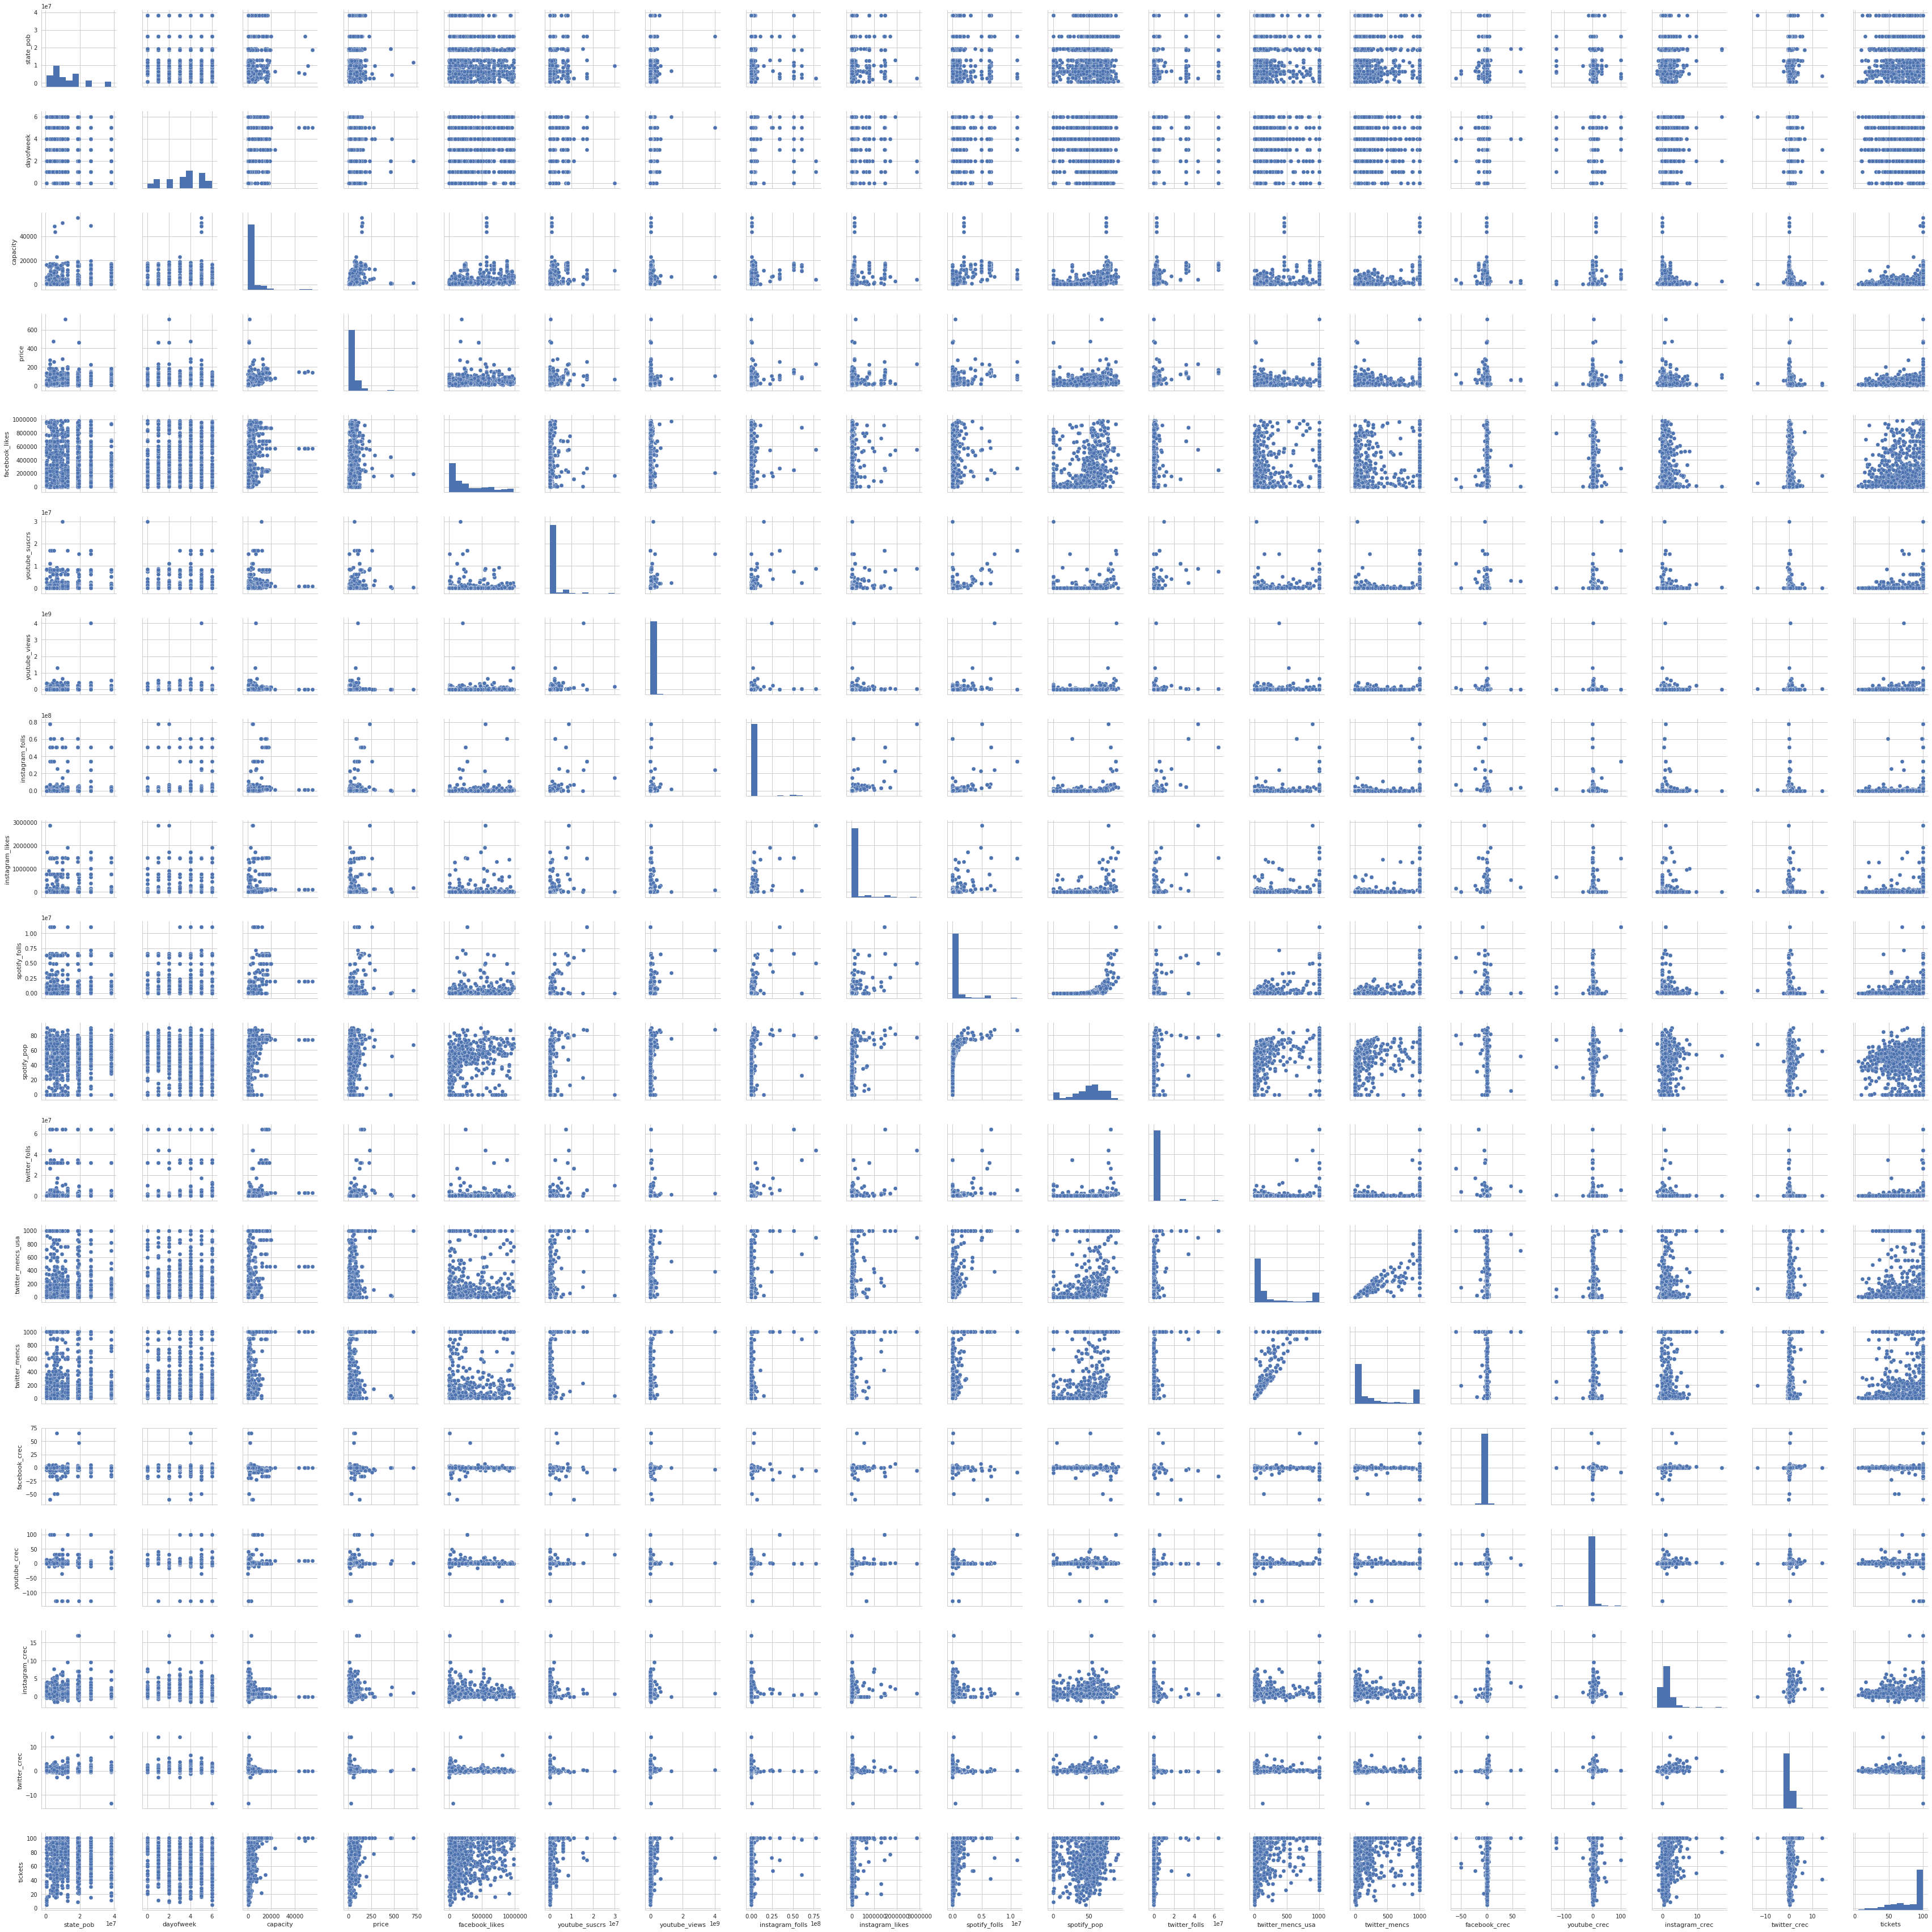

In [38]:
data_df = pd.DataFrame(Xy, columns=['state_pob', 'dayofweek', 'capacity', 'price', 'facebook_likes','youtube_suscrs','youtube_views','instagram_folls','instagram_likes','spotify_folls','spotify_pop','twitter_folls','twitter_mencs_usa','twitter_mencs','facebook_crec','youtube_crec','instagram_crec','twitter_crec','tickets'])
sns.set(style='whitegrid', context='notebook')
features_plot = data_df.columns
data_df[0:10]
sns.pairplot(data_df)#, kind='reg')#, size=2.0);
plt.tight_layout()

A continuacion, se analiza la dispersion entre cada una de las variables independientes y la variable dependiente "tickets".

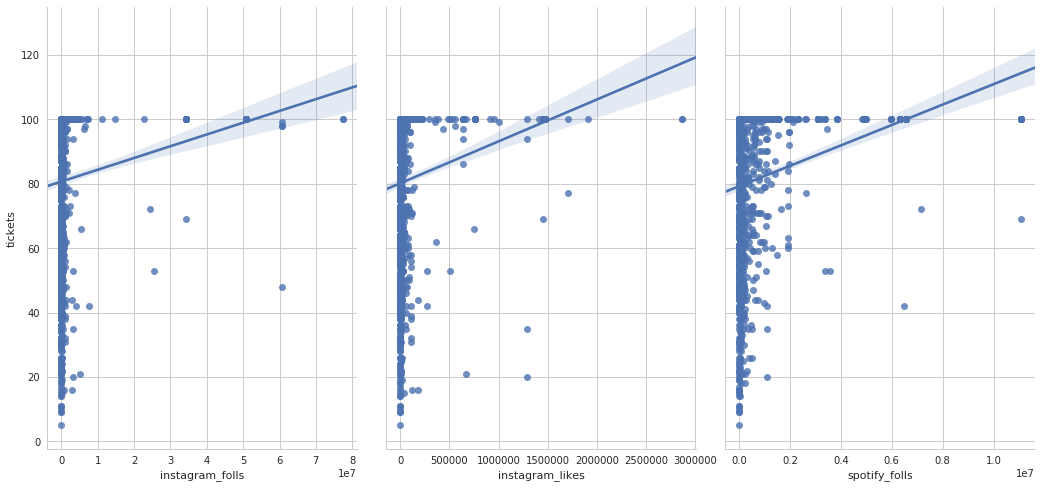

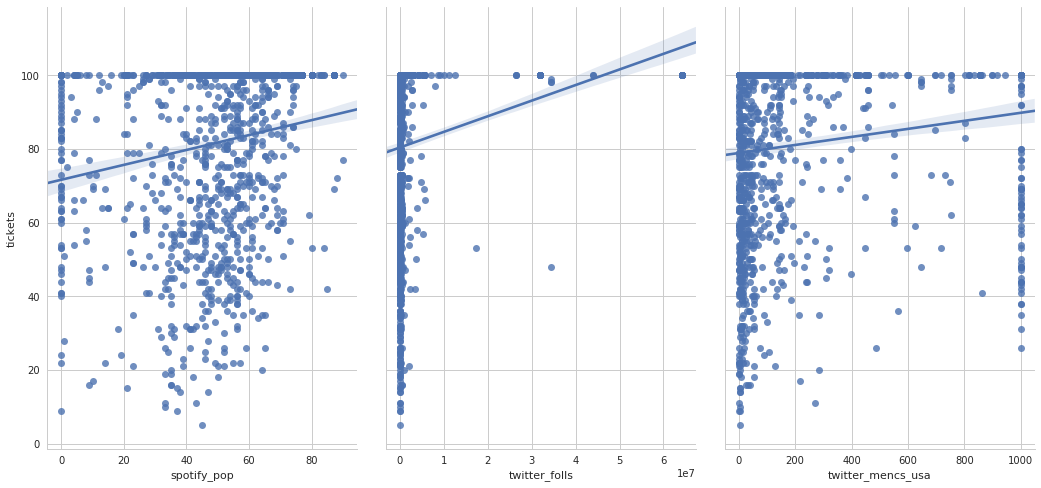

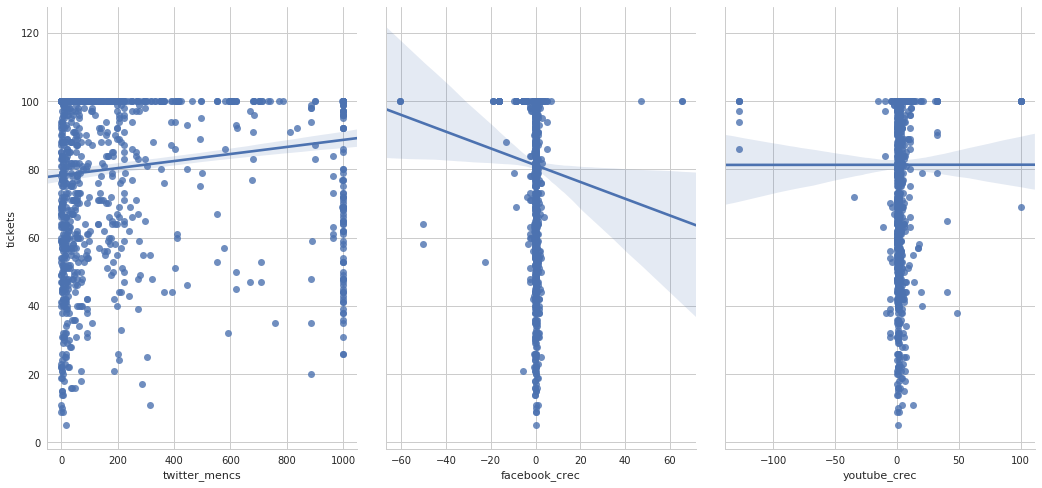

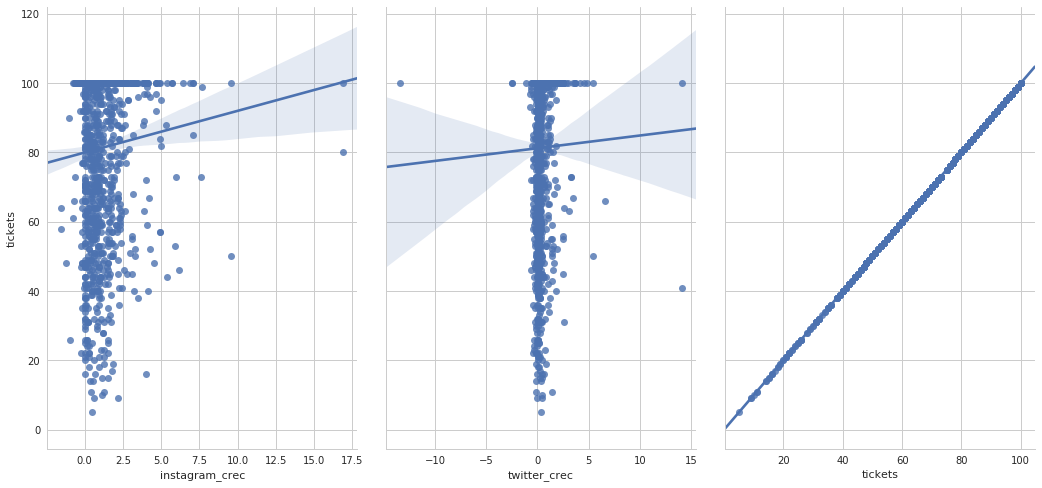

In [41]:
for i in range(8, len(dataset.columns) - 2, 3):
    sns.pairplot(dataset, x_vars= [dataset.columns[i], dataset.columns[i + 1], dataset.columns[i + 2]], y_vars='tickets', size=7, aspect=0.7, kind='reg')

### Analisis de correlacion

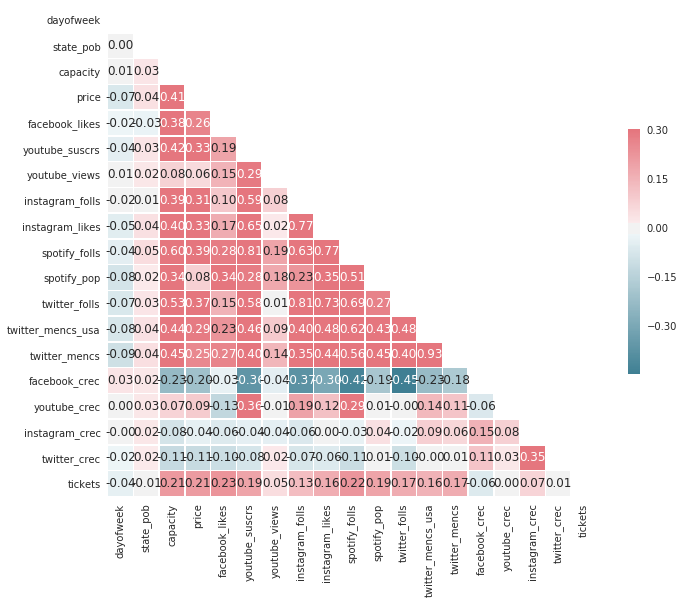

In [42]:
corr_vectors = Xy.corr()
mask = np.zeros_like(corr_vectors, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_vectors, mask=mask, cmap=cmap, vmax=.3, center=0, annot = True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

# Pruebas de modelos
## RandomForest v/s MLP v/s gradient boosting

In [43]:
#tratatamiento de variables categoricas
dummies = pd.get_dummies(dataset['dayofweek'], prefix = 'dayofweek')
data = pd.concat([dummies, dataset], axis=1)
data = data.drop(['dayofweek', 'name'], axis=1)
data.head()

,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,state_pob,capacity,price,...,spotify_folls,spotify_pop,twitter_folls,twitter_mencs_usa,twitter_mencs,facebook_crec,youtube_crec,instagram_crec,twitter_crec,tickets
0,0,0,1,0,0,0,0,18801310,896,32.5,...,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,100
1,0,0,0,1,0,0,0,18801310,464,57.0,...,0.0,0.0,3217,4,6,0.061,0.335,0.933,0.653,70
2,0,0,0,0,0,0,1,6547629,953,29.5,...,3268169.0,84.0,12503006,430,1000,-5.121,0.271,0.000,0.063,100
3,0,0,1,0,0,0,0,6483802,1417,52.5,...,184851.0,57.0,88664,52,58,1.916,1.443,0.458,0.082,98
4,0,0,0,0,1,0,0,38332521,1000,10.0,...,99630.0,56.0,138916,133,196,0.184,0.827,0.488,0.155,67


In [44]:
#separacion features
nombres_col=list(data.columns)
X = data[nombres_col[0:-1]]
y = data[nombres_col[-1]]

### Round 1: RandomForest v/s MLP

In [45]:
exp_MLP=[]
exp_RF=[]
kf = KFold(n_splits=5,shuffle=True)
for i in range(10):
    resultados_RF=[]
    resultados_MLP=[]
    X=np.array(X)

   
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        
        #prediccion con random forest
        rf_reg = RandomForestRegressor()
        rf_reg.fit(X_train,y_train)        
        rf_y_pred = rf_reg.predict(X_test)
        
        #prediccion con red neuronal
        clf = MLPRegressor(hidden_layer_sizes = (90,), activation = 'logistic', solver = 'sgd', warm_start = False)
        scaler = StandardScaler()  
        scaler.fit(X_train)  
        X_train = scaler.transform(X_train)  
        X_test = scaler.transform(X_test)          
        clf.fit(X_train,y_train)
        mlp_y_pred=clf.predict(X_test)
        
        
        resultados_RF.append(mean_squared_error(y_test,rf_y_pred))
        resultados_MLP.append(mean_squared_error(y_test,mlp_y_pred))
        
    print ("Promedio MLP: ",np.mean(resultados_MLP))
    print ("Promedio RandomForest: ",np.mean(resultados_RF))
    
    exp_MLP.append(np.mean(resultados_MLP))
    exp_RF.append(np.mean(resultados_RF))

('Promedio MLP: ', 485.3700535196828)
('Promedio RandomForest: ', 454.8068843762145)
('Promedio MLP: ', 489.3759348087675)
('Promedio RandomForest: ', 441.67970439823813)
('Promedio MLP: ', 484.76403488419066)
('Promedio RandomForest: ', 463.52976470397715)
('Promedio MLP: ', 484.1396392848416)
('Promedio RandomForest: ', 444.62047114263504)
('Promedio MLP: ', 495.4959294303515)
('Promedio RandomForest: ', 451.8441863907242)
('Promedio MLP: ', 490.86996809683933)
('Promedio RandomForest: ', 460.8952023254307)
('Promedio MLP: ', 493.15665815625835)
('Promedio RandomForest: ', 437.35507125275296)
('Promedio MLP: ', 490.88640636616503)
('Promedio RandomForest: ', 472.8921041261821)
('Promedio MLP: ', 496.99344434407794)
('Promedio RandomForest: ', 452.9577758453168)
('Promedio MLP: ', 488.8747560323526)
('Promedio RandomForest: ', 455.46036235263637)


In [46]:
print(exp_MLP)
print(exp_RF)
print("Promedio Experimentos MLP: ", np.mean(exp_MLP),"STD",np.std(exp_MLP))
print("Promedio Experimentos Random Forest Regressor: ", np.mean(exp_RF),"STD",np.std(exp_RF))

[485.3700535196828, 489.3759348087675, 484.76403488419066, 484.1396392848416, 495.4959294303515, 490.86996809683933, 493.15665815625835, 490.88640636616503, 496.99344434407794, 488.8747560323526]
[454.8068843762145, 441.67970439823813, 463.52976470397715, 444.62047114263504, 451.8441863907242, 460.8952023254307, 437.35507125275296, 472.8921041261821, 452.9577758453168, 455.46036235263637]
('Promedio Experimentos MLP: ', 489.99268249235274, 'STD', 4.188928434037597)
('Promedio Experimentos Random Forest Regressor: ', 453.60415269141083, 'STD', 10.094757353325113)


In [47]:
t2, p2 = stats.ttest_ind(exp_MLP,exp_RF)
print("t = " + str(t2))
print("p = " + str(p2))
if p2<0.05:
    print("We reject the NULL Hypothesis. The differences are statistically significant!")
else:
    print("We cannot reject the NULL Hypothesis. The differences are NOT statistically significant!")

t = 9.988273349173152
p = 9.093652595959642e-09
We reject the NULL Hypothesis. The differences are statistically significant!


### Round 2: RandomForest vs GradientBoosting

In [48]:
exp_GRB=[]
exp_RF=[]
kf = KFold(n_splits=5,shuffle=True)
for i in range(10):
    resultados_RF=[]
    resultados_GRB=[]
    X=np.array(X)

   
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        
        #prediccion con random Forest
        rf_reg = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, oob_score=True, n_jobs=4)
        rf_reg.fit(X_train,y_train)        
        rf_y_pred = rf_reg.predict(X_test)
        
        #prediccion con gradient boosting
        grd_boosting = GradientBoostingRegressor(loss='huber', criterion='mse')       
        grd_boosting.fit(X_train,y_train)
        grb_y_pred=grd_boosting.predict(X_test)
        
        
        resultados_RF.append(mean_squared_error(y_test,rf_y_pred))
        resultados_GRB.append(mean_squared_error(y_test,grb_y_pred))
        
    print ("Promedio GradientBoostingRegressor: ",np.mean(resultados_GRB))
    print ("Promedio RandomForest: ",np.mean(resultados_RF))
    
    exp_GRB.append(np.mean(resultados_GRB))
    exp_RF.append(np.mean(resultados_RF))

('Promedio GradientBoostingRegressor: ', 416.4466708460266)
('Promedio RandomForest: ', 416.3657099222934)
('Promedio GradientBoostingRegressor: ', 413.8631443409857)
('Promedio RandomForest: ', 410.46462020364936)
('Promedio GradientBoostingRegressor: ', 407.5433260593832)
('Promedio RandomForest: ', 402.44849964791985)
('Promedio GradientBoostingRegressor: ', 415.3075443298118)
('Promedio RandomForest: ', 410.6715129314738)
('Promedio GradientBoostingRegressor: ', 407.41846030436767)
('Promedio RandomForest: ', 407.80317726919935)
('Promedio GradientBoostingRegressor: ', 413.0615144687252)
('Promedio RandomForest: ', 407.8459145052062)
('Promedio GradientBoostingRegressor: ', 414.38789662628005)
('Promedio RandomForest: ', 410.4487653780038)
('Promedio GradientBoostingRegressor: ', 423.2175974567681)
('Promedio RandomForest: ', 417.8546693934083)
('Promedio GradientBoostingRegressor: ', 417.54419650197934)
('Promedio RandomForest: ', 411.3476871289705)
('Promedio GradientBoostingRegr

In [49]:
print(exp_GRB)
print(exp_RF)
print("Promedio Experimentos GradientBoostingRegressor: ", np.mean(exp_GRB),"STD",np.std(exp_GRB))
print("Promedio Experimentos Random Forest Regressor: ", np.mean(exp_RF),"STD",np.std(exp_RF))

[416.4466708460266, 413.8631443409857, 407.5433260593832, 415.3075443298118, 407.41846030436767, 413.0615144687252, 414.38789662628005, 423.2175974567681, 417.54419650197934, 414.3613332251274]
[416.3657099222934, 410.46462020364936, 402.44849964791985, 410.6715129314738, 407.80317726919935, 407.8459145052062, 410.4487653780038, 417.8546693934083, 411.3476871289705, 409.2128697859877]
('Promedio Experimentos GradientBoostingRegressor: ', 414.31516841594555, 'STD', 4.363643019490532)
('Promedio Experimentos Random Forest Regressor: ', 410.4463426166112, 'STD', 4.123362405417214)


In [50]:
t2, p2 = stats.ttest_ind(exp_GRB,exp_RF)
print("t = " + str(t2))
print("p = " + str(p2))
if p2<0.05:
    print("We reject the NULL Hypothesis. The differences are statistically significant!")
else:
    print("We cannot reject the NULL Hypothesis. The differences are NOT statistically significant!")

t = 1.9332453055182124
p = 0.0690925123767188
We cannot reject the NULL Hypothesis. The differences are NOT statistically significant!


# Modelo ganador: RandomForest

In [51]:
model = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, oob_score=True, n_jobs=4)


### Recursive Feature Elimination
En primer lugar, con el modelo seleccionado, se procede a probar la eliminacion recursiva de caracteristicas. Con esto se busca generar un mejor modelo que utilice menos variables.

In [52]:
from sklearn.feature_selection import RFE

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

rfe = RFE(estimator = model, n_features_to_select=10)
rfe.fit(X_train, y_train)
Xdf = pd.DataFrame(X)
print list(Xdf.columns.values)[:62]
print rfe.support_
y_pred = rfe.predict(X_test)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[False False False False False False False  True  True  True False  True
 False  True  True  True  True  True False False False False False  True]


In [53]:
from sklearn.model_selection import KFold

exp = []
for i in range(10):
    resultados = []
    X=np.array(X)
    kf = KFold(n_splits=5,shuffle=True)
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        model.fit(X_train,y_train)
        y_pred1 = model.predict(X_test)
        resultados.append(np.sqrt(mean_squared_error(y_test,y_pred1)).round(2))
    print str(resultados) + " = " + str(np.mean(resultados).round(2))
    exp.append(np.mean(resultados))
print "\nRMSE mean: " + str(np.mean(exp).round(2)) + ", std: " + str(np.std(exp).round(2))

[20.78, 19.32, 22.0, 18.51, 21.09] = 20.34
[20.44, 19.52, 19.27, 21.08, 21.19] = 20.3
[20.22, 20.05, 20.52, 20.68, 19.94] = 20.28
[19.4, 19.92, 19.07, 21.22, 21.17] = 20.16
[19.88, 21.16, 21.08, 19.46, 20.18] = 20.35
[21.19, 21.68, 18.76, 19.16, 20.34] = 20.23
[19.82, 20.19, 19.5, 21.44, 19.8] = 20.15
[18.65, 19.54, 23.27, 19.33, 20.31] = 20.22
[21.74, 20.38, 18.69, 20.55, 20.0] = 20.27
[19.75, 20.13, 21.73, 20.41, 19.75] = 20.35

RMSE mean: 20.27, std: 0.07


### Seleccion de variables
A continuacion, se realiza una seleccion de algunas de las variables, basados en el analisis de correlacion entre estas.

In [57]:
mapper = sp.DataFrameMapper([
    #('dayofweek', LabelBinarizer()),
    ([
    #'state_pob', 
    'capacity',
    'price', 
    'facebook_likes', 
    'youtube_suscrs', #'youtube_views',
    'instagram_folls', 'instagram_likes',
    'spotify_folls', 'spotify_pop',
    'twitter_folls', 'twitter_mencs', 'twitter_mencs_usa' 
    #'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec'
    ], StandardScaler())
    #], Normalizer())
    #], MinMaxScaler())
    #], RobustScaler())
    ])
X = dataset[[
    #'dayofweek',
    #'state_pob', 
    'capacity',
    'price',
    'facebook_likes', 
    'youtube_suscrs', #'youtube_views',
    'instagram_folls', 'instagram_likes',
    'spotify_folls', 'spotify_pop',
    'twitter_folls', 'twitter_mencs', 'twitter_mencs_usa'
    #'facebook_crec', 'youtube_crec', 'instagram_crec', 'twitter_crec'
    ]]
X = mapper.fit_transform(X)
y = dataset['tickets']

### Modelo de evaluacion de resultados
A continuacion se propone un metodo para evaluar el resultado del modelo. Este consiste en plantear el problema como un problema de clasificacion, donde se establece un umbral para determinar la clase del resultado del evento: positivo o negativo. Con esto, cada evento posee una clase ademas de su valor de % de venta de tickets. Mientras que el modelo predice una clase, a partir del valor predicho por la regresion.

De esta manera, el problema puede ser visto como un problema de clasificacion, evaluando su % de accuracy. Tambien, se presenta una matriz de confusion, con los resultados obtenidos.

### Ejecucion modelo
Finalmente, se ejecuta el modelo de regresion, utilizando validacion cruzada. Aqui se implementa el procedimiendo indicado anteriormente, para evaluar el modelo como un problema de clasificacion y regresion, al mismo tiempo.

Los indicadores de calidad son:
- R^2 : coeficiente de determinacion
- RMSE : raiz del error cuadratico medio
- SCORE: la exactitud de la prediccion de clases

Tambien se muestra la matriz de confusion de cada caso, y el grafico de dispersion de la prediccion vs los valores reales. Finalmente, el modelo con validacion cruzada es ejecutado tres veces, y se entregan los promedios de las iteraciones.

R2: 0.25, RMSE: 21.71, SCORE: 84 / 125 = 0.672
R2: 0.15, RMSE: 19.69, SCORE: 95 / 125 = 0.76
R2: 0.2, RMSE: 23.16, SCORE: 89 / 125 = 0.712
R2: 0.18, RMSE: 21.4, SCORE: 84 / 124 = 0.677
R2: 0.23, RMSE: 21.41, SCORE: 88 / 124 = 0.71
R2: 0.31, RMSE: 19.1, SCORE: 90 / 124 = 0.726
R2: 0.28, RMSE: 20.2, SCORE: 94 / 124 = 0.758
R2: 0.07, RMSE: 20.76, SCORE: 85 / 124 = 0.685
R2: 0.42, RMSE: 18.61, SCORE: 95 / 124 = 0.766
R2: 0.28, RMSE: 17.2, SCORE: 95 / 124 = 0.766

R2s:  0.23739743815302009
RMSEs:  20.324186922038457
scores:  0.7232
coef.corr:  0.4997761306747758
   negativo  positivo
0       153       622
1       277       191



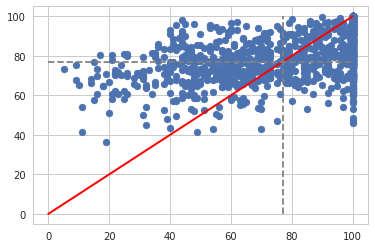

R2: 0.23, RMSE: 21.22, SCORE: 84 / 125 = 0.672
R2: 0.29, RMSE: 19.97, SCORE: 91 / 125 = 0.728
R2: 0.16, RMSE: 20.92, SCORE: 88 / 125 = 0.704
R2: 0.33, RMSE: 20.72, SCORE: 96 / 124 = 0.774
R2: 0.18, RMSE: 20.29, SCORE: 84 / 124 = 0.677
R2: 0.27, RMSE: 19.43, SCORE: 92 / 124 = 0.742
R2: 0.31, RMSE: 18.79, SCORE: 95 / 124 = 0.766
R2: 0.36, RMSE: 19.18, SCORE: 92 / 124 = 0.742
R2: 0.18, RMSE: 20.37, SCORE: 88 / 124 = 0.71
R2: 0.12, RMSE: 22.71, SCORE: 84 / 124 = 0.677

R2s:  0.24388087527744737
RMSEs:  20.360617788399676
scores:  0.7192000000000001
coef.corr:  0.5000193751132845
   negativo  positivo
0       162       626
1       268       187



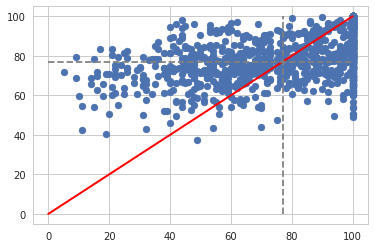

R2: 0.31, RMSE: 18.55, SCORE: 93 / 125 = 0.744
R2: 0.3, RMSE: 22.08, SCORE: 96 / 125 = 0.768
R2: 0.23, RMSE: 19.95, SCORE: 81 / 125 = 0.648
R2: -0.01, RMSE: 22.34, SCORE: 78 / 124 = 0.629
R2: 0.25, RMSE: 20.37, SCORE: 89 / 124 = 0.718
R2: 0.28, RMSE: 19.03, SCORE: 88 / 124 = 0.71
R2: 0.2, RMSE: 19.71, SCORE: 98 / 124 = 0.79
R2: 0.26, RMSE: 20.31, SCORE: 90 / 124 = 0.726
R2: 0.25, RMSE: 21.15, SCORE: 91 / 124 = 0.734
R2: 0.24, RMSE: 21.1, SCORE: 89 / 124 = 0.718

R2s:  0.2316419819717804
RMSEs:  20.459191871340042
scores:  0.7185
coef.corr:  0.49322005082059867
   negativo  positivo
0       157       620
1       273       193



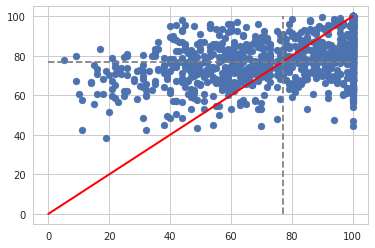

---------------------------------------------
RESUMEN:
r2: 0.23764009846741596
rsme: 20.381332193926056
score: 0.7203


,negativo,positivo
positivo,157.333333,622.666667
negativo,272.666667,190.333333


In [59]:
threshold = 77
all_r2 = []
all_rsme = []
all_score = []
all_aciertos_pos = []
all_aciertos_neg = []
all_errores_pos = []
all_errores_neg = []

for k in range(0, 3):
    r2s = []
    rmses =[]
    scores = []
    X=np.array(X)
    predictions_all = []
    aciertos_pos = []; aciertos_neg = []; errores_pos = []; errores_neg = []
    sum_ylist = 0; sum_pred = 0
    p = 0
    yy = []
    xx = []
    y_list_all = []
    X_list_all = []

    kf = KFold(n_splits=10, shuffle=True)
    for k, (train, test) in enumerate(kf.split(X, y)):
        X_train, X_test = X[train,:], X[test,:]
        y_train, y_test = y[train], y[test]
        model = RandomForestRegressor(n_estimators=1600, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features=4, n_jobs=4)
        #model = MLPRegressor(activation='tanh', solver='sgd', learning_rate='adaptive', max_iter=900)
        #model = AdaBoostRegressor(base_estimator=None)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        predictions = y_pred.copy()

        sum = 0; aciertos_positivo = 0; aciertos_negativo = 0
        errores_positivo = 0; errores_negativo = 0
        sum_positivo = 0; sum_negativo = 0
        sum_predict_positivo = 0; sum_predict_negativo = 0
        total_test = len(X_test)
        X_list = list(X_test)
        y_list = list(y_test)

        for k in range(0, len(predictions)):
            sum += abs(predictions[k] - y_list[k])
            if y_list[k] >= threshold and predictions[k] >= threshold:
                aciertos_positivo += 1
            if y_list[k] >= threshold and predictions[k] < threshold:
                errores_positivo += 1
            if y_list[k] < threshold and predictions[k] < threshold:
                aciertos_negativo += 1
            if y_list[k] < threshold and predictions[k] >= threshold:
                errores_negativo += 1
            if y_list[k] >= threshold:
                sum_positivo += 1
            else:
                sum_negativo += 1
            if predictions[k] >= threshold:
                sum_predict_positivo += 1
            else:
                sum_predict_negativo += 1

        print "R2: " + str(round(r2_score(y_list, predictions), 2)) + ',',
        print "RMSE: " + str(round(np.sqrt(mean_squared_error(predictions, y_list)), 2)) + ',',
        print "SCORE: " + str(aciertos_positivo + aciertos_negativo) + " / " + str(total_test) + " = " + str(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))
        df = pd.DataFrame({'real': y_list, 'prediction': predictions})

        aciertos_pos.append(aciertos_positivo)
        aciertos_neg.append(aciertos_negativo)
        errores_pos.append(errores_positivo)
        errores_neg.append(errores_negativo)

        r2s.append(r2_score(y_list, predictions))
        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        scores.append(round(1.0 * (aciertos_positivo + aciertos_negativo)/total_test, 3))

        predictions_all.extend(predictions)
        X_list_all.extend(X_list)
        y_list_all.extend(y_list)

        sum_ylist += np.sum(y_list)
        sum_pred  += np.sum(predictions)

        p += 1

    print
    print "R2s: ", np.mean(r2s)
    print "RMSEs: ",np.mean(rmses)
    print "scores: ", np.mean(scores)
    print "coef.corr: " , np.corrcoef(y_list_all, predictions_all)[0][1]
    conf = pd.DataFrame([[np.sum(errores_neg), np.sum(aciertos_pos)], [np.sum(aciertos_neg), np.sum(errores_pos)]], columns=['negativo', 'positivo'])
    conf.rename(index={0:'negativo', 1:'positivo'})
    print conf
    print

    #for i in range(0, len(y_list_all)):
    #    if y_list_all[i] == 100 and predictions_all[i] < 60:
    #        print str(X_list_all[i]) + ' = ' + str(y_list_all[i]) + ' / ' + str(predictions_all[i])
    
    plt.scatter(y_list_all, predictions_all)
    plt.plot([0, 100], [0, 100], c='r', lw=2)
    ax = plt.gca()
    line_h = mlines.Line2D([0,100], [threshold, threshold], color='gray', ls='dashed')
    line_v = mlines.Line2D([threshold, threshold], [0,100], color='gray', ls='dashed')
    ax.add_line(line_h)
    ax.add_line(line_v)
    #x0 = [0, 0, 35, 35]
    #y0 = [0, threshold, threshold, 0]
    #ax.fill(x0, y0, alpha=0.2)
    plt.show()
    
    all_r2.append(np.mean(r2s))
    all_rsme.append(np.mean(rmses))
    all_score.append(np.mean(scores))
    all_aciertos_pos.append(np.sum(aciertos_pos))
    all_aciertos_neg.append(np.sum(aciertos_neg))
    all_errores_pos.append(np.sum(errores_pos))
    all_errores_neg.append(np.sum(errores_neg))

print '---------------------------------------------'
print 'RESUMEN:'
print "r2: " + str(np.mean(all_r2))
print "rsme: " + str(np.mean(all_rsme))
print "score: " + str(np.mean(all_score))

conf = pd.DataFrame([[np.mean(all_errores_neg), np.mean(all_aciertos_pos)], [np.mean(all_aciertos_neg), np.mean(all_errores_pos)]], columns=['negativo', 'positivo'])
conf.rename(index={0:'positivo', 1:'negativo'})

A continuación se muestra, a modo de ejemplo, una categorización de clases para los valores de tickets.

In [60]:
df = pd.DataFrame(y_list_all)
df.columns = ['tickets']
df.insert(loc=1, column='predictions', value=np.round(predictions_all))
y_label = copy.copy(y_list_all)
type(y_label)
for k in range(0, len(y_label)):
    if y_label[k] >= threshold:
        y_label[k] = 'positivo'
    else:
        y_label[k] = 'negativo'

predictions_label = pd.Series(predictions_all)
predictions_label[predictions_label>=threshold] = 'positivo'
predictions_label[predictions_label<threshold] = 'negativo'

df1 = pd.DataFrame(y_label)
df1.insert(loc=1, column='predictions', value=predictions_label)

df.insert(loc=2, column='tickets-class', value=df1[0].tolist())
df.insert(loc=3, column='predictions-class', value=df1['predictions'].tolist())
df.head()

,tickets,predictions,tickets-class,predictions-class
0,100,90.0,positivo,positivo
1,60,53.0,negativo,negativo
2,100,95.0,positivo,positivo
3,60,96.0,negativo,positivo
4,81,89.0,positivo,positivo
